## **Imports** 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import plotly.subplots as sp
from scipy import stats
import math
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.feature_selection import SelectKBest, chi2, f_classif, RFE, RFECV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Lasso
from tqdm import tqdm
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV, KFold



In [3]:
diab_df=pd.read_csv('/Users/vladandreichuk/Desktop/Comparative-Analysis-of-ML-Algorithms-Predicting-Hospital-Readmission-of-Diabetes-Patients/CP_Hospital_Readmission/diab_df_cleaned.csv')

In [4]:
diab_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 44 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   race                      101766 non-null  object
 1   gender                    101766 non-null  object
 2   age                       101766 non-null  object
 3   admission_type_id         101766 non-null  int64 
 4   discharge_disposition_id  101766 non-null  int64 
 5   admission_source_id       101766 non-null  int64 
 6   time_in_hospital          101766 non-null  int64 
 7   num_lab_procedures        101766 non-null  int64 
 8   num_procedures            101766 non-null  int64 
 9   num_medications           101766 non-null  int64 
 10  number_inpatient          101766 non-null  int64 
 11  diag_1                    101766 non-null  object
 12  diag_2                    101766 non-null  object
 13  diag_3                    101766 non-null  object
 14  numb

## **Correlation Analysis**


In [4]:
# Select only the numeric columns for correlation analysis
num_cols_df= diab_df.select_dtypes(include=['number'])

# Calculate the correlation matrix for the numeric columns
correlation_matrix = num_cols_df.corr()

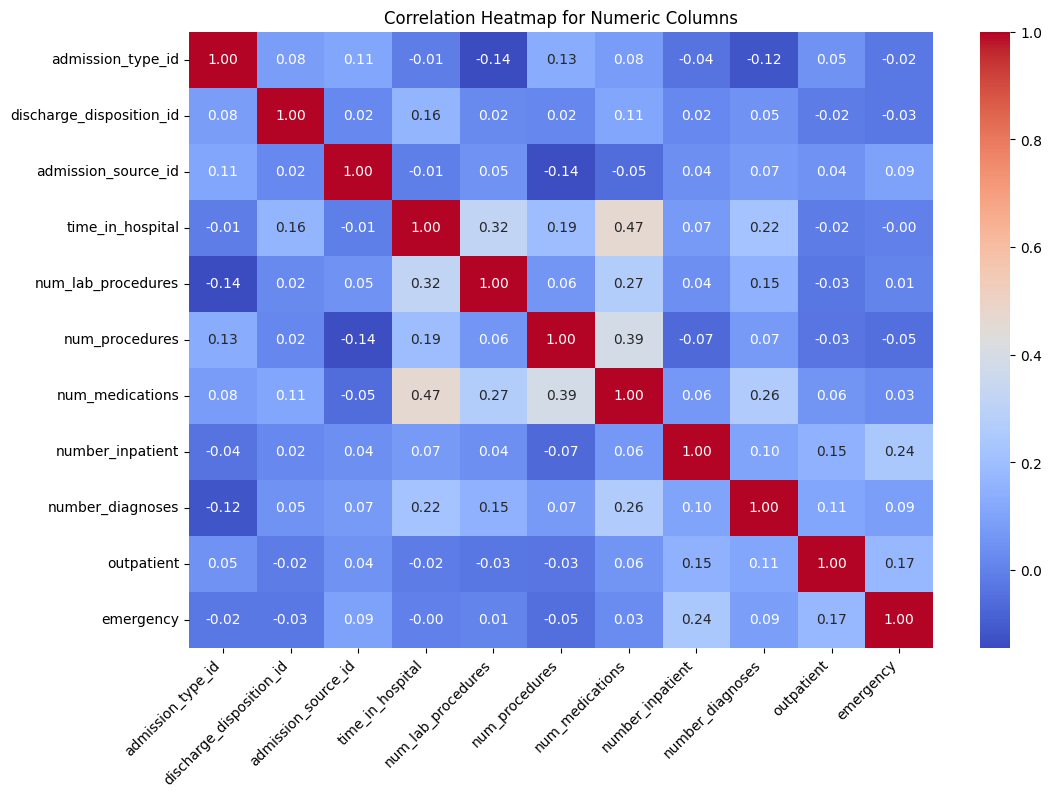

In [5]:
# Create a heatmap
plt.figure(figsize=(12, 8))
heatmap = sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
# Rotate x-ticks
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=45, ha='right')
plt.title("Correlation Heatmap for Numeric Columns")
plt.show()

## **Chi2 Analysis**

### **Approach 1**

In [5]:
# Separate the target variable from the features
X = diab_df.drop(columns=['readmitted'])  # Features
y = diab_df['readmitted']  # Target variable

# Format all fields as string
X_str = X.astype(str)

# Encode input data
def encode_inputs(X):
    oe = OrdinalEncoder()
    oe.fit(X)
    X_enc = oe.transform(X)
    return X_enc


# Encode target variable
def encode_targets(y):
    le = LabelEncoder()
    le.fit(y)
    y_enc = le.transform(y)
    return y_enc

In [6]:
# Transform X
X_enc = encode_inputs(X_str)

# Transform y
y_enc = encode_targets(y)

In [7]:
# Calculate Chi-squared and P-value between features and the target variable
chi2_stat, chi2_p_values = chi2(X_enc, y_enc)

# Create a DataFrame to store the results
chi2_df = pd.DataFrame({'Feature': X.columns, 'Chi2': chi2_stat,'P_value': chi2_p_values})

# Sort the DataFrame by Chi2 values in ascending order
chi2_df = chi2_df.sort_values(by='Chi2', ascending=True)


print(chi2_df)


                     Feature          Chi2        P_value
29                  miglitol      0.001587   9.992069e-01
20            chlorpropamide      0.003962   9.980208e-01
33       glyburide-metformin      0.008182   9.959172e-01
19               nateglinide      0.014735   9.926597e-01
28                  acarbose      0.099620   9.514102e-01
24                 glyburide      0.410592   8.144063e-01
0                       race      0.413343   8.132869e-01
21               glimepiride      0.446211   8.000304e-01
32                   insulin      0.504072   7.772168e-01
18               repaglinide      0.732074   6.934772e-01
16                 A1Cresult      0.811650   6.664268e-01
15             max_glu_serum      0.815882   6.650180e-01
37    metformin-pioglitazone      0.854878   6.521773e-01
30              troglitazone      1.435651   4.878119e-01
27             rosiglitazone      1.507989   4.704835e-01
25               tolbutamide      1.634609   4.416205e-01
26            

In [8]:
# Visualize the Chi2 values for each feature on a log scale in ascending order
fig = px.bar(chi2_df,x = 'Feature', y = 'Chi2',log_y=True)
fig.update_layout(title="Chi-squared values for all features and 'readmitted' target variable", yaxis_title="Chi2 (Log10 scale)",xaxis_title="Features") 
fig.update_xaxes(tickangle=-45)

In [15]:
# Select the columns to drop with high p-value and low Chi2
cols_to_drop_chi2_1= chi2_df[(chi2_df['P_value']>=0.05) | (chi2_df['Chi2']<=15)]['Feature'].tolist()
cols_to_drop_chi2_1

['miglitol',
 'chlorpropamide',
 'glyburide-metformin',
 'nateglinide',
 'acarbose',
 'glyburide',
 'race',
 'glimepiride',
 'insulin',
 'repaglinide',
 'A1Cresult',
 'max_glu_serum',
 'metformin-pioglitazone',
 'troglitazone',
 'rosiglitazone',
 'tolbutamide',
 'pioglitazone',
 'metformin-rosiglitazone',
 'acetohexamide',
 'glimepiride-pioglitazone',
 'tolazamide',
 'glipizide-metformin',
 'glipizide']

### **Approach 2**

In [16]:
# Alternative method to the above using SelectKBest
def skb_chi2(X, y):
    fs = SelectKBest(score_func=chi2, k='all')
    fs.fit(X, y)
    return fs

In [17]:
results_scores =[]
# Get the Chi2 results
for i in range(100):
    results = skb_chi2(X_enc, y_enc)
    results_scores.append(results.scores_)

skb_chi2_results = np.mean(results_scores,axis=0)    

In [18]:
# Print all the Chi2 values for all features
for i in range(len(skb_chi2_results)):
    print(f'Feature {X.columns[i]}: {skb_chi2_results[i]}')

 # Visualize the Chi2 values for each feature on a log scale in ascending order         
fig = px.bar(x = X.columns, y = skb_chi2_results,log_y=True)
fig.update_layout(xaxis={'categoryorder':'total ascending'}, title="Chi-squared values for all features and 'readmitted' target variable", yaxis_title="Chi2 (Log10 scale)") 
fig.update_xaxes(tickangle=-45)

Feature race: 0.4133427681512666
Feature gender: 18.923993559566437
Feature age: 40.98462650726148
Feature admission_type_id: 28.236320436568025
Feature discharge_disposition_id: 9582.673912275823
Feature admission_source_id: 871.1258835388343
Feature time_in_hospital: 628.9788299578851
Feature num_lab_procedures: 1190.372000309406
Feature num_procedures: 448.86062652249524
Feature num_medications: 8004.147635412751
Feature number_inpatient: 49337.57997818581
Feature diag_1: 834.6479993418559
Feature diag_2: 33.49376704163807
Feature diag_3: 515.6753413877718
Feature number_diagnoses: 380.6979099170421
Feature max_glu_serum: 0.8158822281590787
Feature A1Cresult: 0.8116500635438284
Feature metformin: 15.68068707754872
Feature repaglinide: 0.7320737433649878
Feature nateglinide: 0.014734721106014486
Feature chlorpropamide: 0.003962341975988642
Feature glimepiride: 0.4462109854288487
Feature acetohexamide: 1.8630187086803007
Feature glipizide: 3.4064155698207554
Feature glyburide: 0.41059

In [19]:
# Create a temporary DataFrame to store the results 
chi2_results_df = pd.DataFrame({'Feature': X.columns,
                                'Chi-squared Statistic': skb_chi2_results})

In [20]:
# Sort rows by the Chi2 values in ascending order
chi2_results_df_sorted = chi2_results_df.sort_values(by='Chi-squared Statistic',ascending=True)

In [22]:
# Select 23 features (to match the size of the previous result) with lowest Chi2
cols_to_drop_chi2_2 = list(chi2_results_df_sorted[:23]['Feature'])
cols_to_drop_chi2_2

['miglitol',
 'chlorpropamide',
 'glyburide-metformin',
 'nateglinide',
 'acarbose',
 'glyburide',
 'race',
 'glimepiride',
 'insulin',
 'repaglinide',
 'A1Cresult',
 'max_glu_serum',
 'metformin-pioglitazone',
 'troglitazone',
 'rosiglitazone',
 'tolbutamide',
 'pioglitazone',
 'metformin-rosiglitazone',
 'acetohexamide',
 'glimepiride-pioglitazone',
 'tolazamide',
 'glipizide-metformin',
 'glipizide']

## **Mutual Information Analysis**

### **Approach 1**

In [23]:
# Calculate mutual information between features and the target variable
mutual_info = mutual_info_classif(X_enc, y_enc)

# Create a DataFrame to store the results
mutual_info_df = pd.DataFrame({'Feature': X.columns, 'Mutual_Info': mutual_info})

# Sort the DataFrame by mutual information values in ascending order
mutual_info_df = mutual_info_df.sort_values(by='Mutual_Info', ascending=True)

print(mutual_info_df)

                     Feature  Mutual_Info
31                tolazamide     0.000000
8             num_procedures     0.000247
35  glimepiride-pioglitazone     0.000656
34       glipizide-metformin     0.000690
36   metformin-rosiglitazone     0.000804
22             acetohexamide     0.001111
7         num_lab_procedures     0.001278
30              troglitazone     0.001600
37    metformin-pioglitazone     0.002751
32                   insulin     0.003455
41                outpatient     0.003717
26              pioglitazone     0.004002
6           time_in_hospital     0.004031
3          admission_type_id     0.004504
2                        age     0.004561
25               tolbutamide     0.004840
1                     gender     0.004953
24                 glyburide     0.005643
42                 emergency     0.005676
9            num_medications     0.005786
38                    change     0.005912
16                 A1Cresult     0.006133
27             rosiglitazone     0

In [25]:
# Visualize the MI values for each feature in ascending order
fig = px.bar(mutual_info_df, x = 'Feature', y = 'Mutual_Info')
fig.update_layout(title="Mutual Information values for all features and 'readmitted' target variable", yaxis_title="Mutual information",xaxis_title="Features") 
fig.update_xaxes(tickangle=-45)

In [26]:
# Select 23 features (to match the size of the previous result) with lowest Mutual Information
cols_to_drop_mi_1 = list(mutual_info_df[:23]['Feature'])
cols_to_drop_mi_1

['tolazamide',
 'num_procedures',
 'glimepiride-pioglitazone',
 'glipizide-metformin',
 'metformin-rosiglitazone',
 'acetohexamide',
 'num_lab_procedures',
 'troglitazone',
 'metformin-pioglitazone',
 'insulin',
 'outpatient',
 'pioglitazone',
 'time_in_hospital',
 'admission_type_id',
 'age',
 'tolbutamide',
 'gender',
 'glyburide',
 'emergency',
 'num_medications',
 'change',
 'A1Cresult',
 'rosiglitazone']

### **Approach 2**

In [27]:
# Alternative method to the above using SelectKBest
def skb_mut_inf(X, y):
    fs = SelectKBest(score_func=mutual_info_classif, k='all')
    fs.fit(X, y)
    return fs

In [29]:
results_scores =[]

# Get the MI results
for i in range(10):
    results = skb_mut_inf(X_enc, y_enc)
    results_scores.append(results.scores_)

skb_mi_results = np.mean(results_scores,axis=0)    

In [30]:
# Show the scores for the features
for i in range(len(skb_mi_results)):
    print(f'Feature {X.columns[i]}: {skb_mi_results[i]}')
    
# Visualize the MI values for each feature in ascending order        
fig = px.bar(x = X.columns, y = skb_mi_results)
fig.update_layout(xaxis={'categoryorder':'total ascending'}, title="MI values for all features and 'readmitted' target variable", yaxis_title="Mutual information") 
fig.update_xaxes(tickangle=-45)

Feature race: 0.008908746350649154
Feature gender: 0.006000309605122589
Feature age: 0.003266487512742655
Feature admission_type_id: 0.00307746252376635
Feature discharge_disposition_id: 0.01997427961985676
Feature admission_source_id: 0.01151053570888987
Feature time_in_hospital: 0.0034430953513494788
Feature num_lab_procedures: 0.0009732760303481358
Feature num_procedures: 0.0019097811866570114
Feature num_medications: 0.004611799909381165
Feature number_inpatient: 0.030342477933648925
Feature diag_1: 0.018765423984227446
Feature diag_2: 0.013493532149867704
Feature diag_3: 0.012397550882428155
Feature number_diagnoses: 0.007637325881248813
Feature max_glu_serum: 0.008334980179105323
Feature A1Cresult: 0.005885077470598699
Feature metformin: 0.007498396524467488
Feature repaglinide: 0.007986369390759718
Feature nateglinide: 0.00919982525783063
Feature chlorpropamide: 0.00751684850122647
Feature glimepiride: 0.01134824454380634
Feature acetohexamide: 0.0006103049002439187
Feature glip

In [32]:
# Create a temporary DataFrame to store the results 
mi_results_df = pd.DataFrame({'Feature': X.columns,
                                  'MI Statistic': skb_mi_results})

In [33]:
# Sort rows by the MI values in ascending order
mi_results_df_sorted = mi_results_df.sort_values(by='MI Statistic',ascending=True)

In [34]:
# Select 23 features (to match the size of the previous result) with lowest MI
cols_to_drop_mi_2 = list(mi_results_df_sorted[:23]['Feature'])
cols_to_drop_mi_2

['glipizide-metformin',
 'troglitazone',
 'tolbutamide',
 'metformin-rosiglitazone',
 'acetohexamide',
 'glimepiride-pioglitazone',
 'num_lab_procedures',
 'metformin-pioglitazone',
 'tolazamide',
 'num_procedures',
 'admission_type_id',
 'age',
 'time_in_hospital',
 'num_medications',
 'outliers',
 'rosiglitazone',
 'pioglitazone',
 'A1Cresult',
 'gender',
 'outpatient',
 'glyburide',
 'insulin',
 'glipizide']

## **ANOVA f-test**

### **Approach 1**

In [35]:
# Calculate the F-statistic and p-values for each feature
f_values, p_values = f_classif(X_enc, y_enc)

# Create a DataFrame to store the results
anova_f_df = pd.DataFrame({'Feature': X.columns, 'F_Value': f_values, 'P_Value': p_values})

# Sort the DataFrame by F-values in ascending order
anova_f_df = anova_f_df.sort_values(by='F_Value', ascending=True)

print(anova_f_df)

                     Feature      F_Value        P_Value
12                    diag_2     0.194236   8.234641e-01
37    metformin-pioglitazone     0.427434   6.521816e-01
0                       race     0.472321   6.235546e-01
32                   insulin     0.503459   6.044377e-01
33       glyburide-metformin     0.578083   5.609744e-01
30              troglitazone     0.717836   4.878094e-01
25               tolbutamide     0.817478   4.415467e-01
36   metformin-rosiglitazone     0.854883   4.253358e-01
35  glimepiride-pioglitazone     0.931508   3.939625e-01
22             acetohexamide     0.931508   3.939625e-01
31                tolazamide     0.964258   3.812693e-01
19               nateglinide     0.980285   3.752077e-01
34       glipizide-metformin     1.023986   3.591640e-01
29                  miglitol     1.835911   1.594734e-01
24                 glyburide     1.911987   1.477917e-01
20            chlorpropamide     1.941831   1.434463e-01
13                    diag_3   

In [36]:
# Visualize the F-test results for all features
fig = px.bar(anova_f_df, x = 'Feature', y = 'F_Value')
fig.update_layout(title="ANOVA f-test values for all features and 'readmitted' target variable", yaxis_title="F-test value",xaxis_title="Features") 
fig.update_xaxes(tickangle=-45)

In [39]:
# Select the columns to drop with high p-value and low f_value
cols_to_drop_anova_f_1= anova_f_df[(anova_f_df['P_Value']>=0.05) | (anova_f_df['F_Value']<=11)]['Feature'].tolist()
cols_to_drop_anova_f_1

['diag_2',
 'metformin-pioglitazone',
 'race',
 'insulin',
 'glyburide-metformin',
 'troglitazone',
 'tolbutamide',
 'metformin-rosiglitazone',
 'glimepiride-pioglitazone',
 'acetohexamide',
 'tolazamide',
 'nateglinide',
 'glipizide-metformin',
 'miglitol',
 'glyburide',
 'chlorpropamide',
 'diag_3',
 'A1Cresult',
 'glimepiride',
 'diag_1',
 'admission_type_id',
 'max_glu_serum']

### **Approach 2**

In [40]:
# Alternative method to the above using SelectKBest
def skb_anova_f(X, y):
    fs = SelectKBest(score_func=f_classif, k='all')
    fs.fit(X, y)
    return fs

In [41]:
results_scores =[]

# Get the F-test results
for i in range(100):
    results = skb_anova_f(X_enc, y_enc)
    results_scores.append(results.scores_)

skb_anova_f_results = np.mean(results_scores,axis=0)    

In [42]:
# what are scores for the features
for i in range(len(skb_anova_f_results)):
    print(f'Feature {X.columns[i]}: {skb_anova_f_results[i]}')

# Visualize the ANOVA f-test values for each feature in ascending order        
fig = px.bar(x = X.columns, y = skb_anova_f_results)
fig.update_layout(xaxis={'categoryorder':'total ascending'}, title="ANOVA f-test values for all features and 'readmitted' target variable", yaxis_title="ANOVA f-test values") 
fig.update_xaxes(tickangle=-45)

Feature race: 0.47232113858375924
Feature gender: 17.60325212654271
Feature age: 49.21245165014543
Feature admission_type_id: 6.920753178123615
Feature discharge_disposition_id: 400.1609995497318
Feature admission_source_id: 100.61650426149632
Feature time_in_hospital: 164.4808313744393
Feature num_lab_procedures: 70.79475468697098
Feature num_procedures: 103.54126709214856
Feature num_medications: 155.05620703377681
Feature number_inpatient: 2487.960437392095
Feature diag_1: 5.4475650633952855
Feature diag_2: 0.1942356370652621
Feature diag_3: 2.2098836082918543
Feature number_diagnoses: 632.7420289581408
Feature max_glu_serum: 8.427139344155455
Feature A1Cresult: 2.8646624726077086
Feature metformin: 49.48479336391211
Feature repaglinide: 20.50541348408211
Feature nateglinide: 0.9802849070104749
Feature chlorpropamide: 1.9418313726825929
Feature glimepiride: 4.0332601402159165
Feature acetohexamide: 0.9315081004537535
Feature glipizide: 14.39847970988709
Feature glyburide: 1.91198719

In [44]:
# Create a temporary DataFrame to store the results 
anova_f_results_df = pd.DataFrame({'Feature': X.columns,
                                'ANOVA f-test Statistic': skb_anova_f_results})

In [45]:
# Sort rows by the F values in ascending order
anova_f_results_df_sorted = anova_f_results_df.sort_values(by='ANOVA f-test Statistic',ascending=True)

In [46]:
# Select 23 features (to match the size of the previous result) with lowest F values
cols_to_drop_anova_f_2 = list(anova_f_results_df_sorted[23:]['Feature'])
cols_to_drop_anova_f_2

['rosiglitazone',
 'glipizide',
 'acarbose',
 'gender',
 'repaglinide',
 'age',
 'metformin',
 'num_lab_procedures',
 'admission_source_id',
 'num_procedures',
 'change',
 'num_medications',
 'time_in_hospital',
 'diabetesMed',
 'discharge_disposition_id',
 'outliers',
 'outpatient',
 'number_diagnoses',
 'emergency',
 'number_inpatient']

## **Recursive Feature Elimination (RFE)**

In [63]:
def rfe_fs(X,y,col_names,estimator, k):

    # Initialize RFE with the estimator and the number of features to select
    selector = RFE(estimator, n_features_to_select=k)

    # Fit RFE to the dataset with a progress bar
    with tqdm(total=k, desc="RFE Progress") as pbar:
        for step in range(k):
            selector.fit(X, y)
            # Update the progress bar
            pbar.update(1)

    # Get the list of columns to delete (least important features)
    deleted_features= col_names[~selector.support_]

    # Create a DataFrame of feature importances
    feature_importances = pd.DataFrame({'Feature': col_names, 'Importance': selector.ranking_})

    # Sort the DataFrame by importance (ascending order) to arrange features from least important to most important
    feature_importances = feature_importances.sort_values(by='Importance', ascending=True)

    return selector, deleted_features, feature_importances

In [64]:
rfe_model, cols_to_drop_rfe, rfe_results_df = rfe_fs(X_enc,y_enc,X.columns,estimator=RandomForestClassifier(), k=23)

RFE Progress: 100%|██████████| 23/23 [11:30:44<00:00, 1801.93s/it]  


In [63]:
k=23

# Initialize the estimator (model) we want to use for feature ranking
estimator = RandomForestClassifier()  

    # Initialize RFE with the estimator and the number of features to select
selector = RFE(estimator, n_features_to_select=k)

    # Fit RFE to the dataset with a progress bar
with tqdm(total=k, desc="RFE Progress") as pbar:
    for step in range(k):
        selector.fit(X_enc, y_enc)
        # Update the progress bar
        pbar.update(1)

    # Get the selected feature indices
selected_feature_indices = selector.support_


    # Get the list of columns to delete (least important features)
deleted_feature_indices = ~selected_feature_indices
deleted_feature_names = X.columns[deleted_feature_indices]

    # Create a DataFrame of feature importances
feature_importances = pd.DataFrame({'Feature': X.columns, 'Importance': selector.ranking_})

    # Sort the DataFrame by importance (ascending order) to arrange features from least important to most important
feature_importances = feature_importances.sort_values(by='Importance', ascending=True)



RFE Progress: 100%|██████████| 23/23 [2:58:26<00:00, 465.51s/it]  


In [73]:
deleted_feature_names

Index(['max_glu_serum', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'tolbutamide', 'rosiglitazone',
       'acarbose', 'miglitol', 'troglitazone', 'tolazamide',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'diabetesMed', 'outliers', 'outpatient'],
      dtype='object')

In [64]:
feature_importances

,Feature,Importance
0,race,1
38,change,1
32,insulin,1
26,pioglitazone,1
24,glyburide,1
23,glipizide,1
17,metformin,1
16,A1Cresult,1
14,number_diagnoses,1
13,diag_3,1


In [71]:
# summarize all features
for i in range(X.shape[1]):
    print('Column: %s, Selected %s, Rank: %.3f' % (X.columns[i], selector.support_[i], selector.ranking_[i]))

Column: race, Selected True, Rank: 1.000
Column: gender, Selected True, Rank: 1.000
Column: age, Selected True, Rank: 1.000
Column: admission_type_id, Selected True, Rank: 1.000
Column: discharge_disposition_id, Selected True, Rank: 1.000
Column: admission_source_id, Selected True, Rank: 1.000
Column: time_in_hospital, Selected True, Rank: 1.000
Column: num_lab_procedures, Selected True, Rank: 1.000
Column: num_procedures, Selected True, Rank: 1.000
Column: num_medications, Selected True, Rank: 1.000
Column: number_inpatient, Selected True, Rank: 1.000
Column: diag_1, Selected True, Rank: 1.000
Column: diag_2, Selected True, Rank: 1.000
Column: diag_3, Selected True, Rank: 1.000
Column: number_diagnoses, Selected True, Rank: 1.000
Column: max_glu_serum, Selected False, Rank: 6.000
Column: A1Cresult, Selected True, Rank: 1.000
Column: metformin, Selected True, Rank: 1.000
Column: repaglinide, Selected False, Rank: 8.000
Column: nateglinide, Selected False, Rank: 10.000
Column: chlorprop

In [65]:
# Create a bar chart to visualize RFE feature ranks
fig = px.bar(rfe_results_df, x='Feature', y='Importance')
fig.update_layout(
    title="Feature Importances (RFE)",
    yaxis_title="Importance",
    xaxis_title="Features",
    xaxis={'categoryorder': 'total descending'}  # Arrange features from least to most important
)
fig.show()

# Print the list of deleted feature names
print("Deleted Features:")
print(cols_to_drop_rfe)

Deleted Features:
Index(['max_glu_serum', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'tolbutamide', 'rosiglitazone',
       'acarbose', 'miglitol', 'troglitazone', 'tolazamide',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'diabetesMed', 'outliers', 'outpatient'],
      dtype='object')


## **Lasso**

In [60]:
def lasso_fs(X, y, col_names,params,n_splits):

    # Number of Folds and adding the random state for replication
    kf=KFold(n_splits=n_splits,shuffle=True, random_state=42)

    # Initializing the Model
    model= Lasso()

    # GridSearchCV with model, params and folds.
    lasso_gs=GridSearchCV(model, param_grid=params, cv=kf)
    lasso_gs.fit(X, y)

    lasso = Lasso(alpha=lasso_gs.best_params_['alpha'])

    lasso.fit(X_enc, y_enc)

    # Get the coefficients (feature importances) 
    feature_importances = np.abs(lasso.coef_)

    # Create a DataFrame to store the feature importances
    feature_importances_df = pd.DataFrame({'Feature': col_names, 'Importance': feature_importances})

    # Sort the DataFrame by importance (ascending order) to arrange features from less important to most important
    feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=True)

    # Get the list of columns to exclude (least important features)
    excluded_feature_names = feature_importances_df[feature_importances_df['Importance'] == 0]['Feature']

    return lasso, feature_importances_df, list(excluded_feature_names)


In [61]:
# parameters to be tested on GridSearchCV
params = {"alpha":np.arange(0.00001, 10, 500)}

lasso_model, lasso_results_df , cols_to_drop_lasso = lasso_fs(X_enc, y_enc, col_names=X.columns,params=params,n_splits=5)

In [62]:
# Create a bar chart to visualize feature importances
fig = px.bar(lasso_results_df, x='Feature', y='Importance')
fig.update_layout(
        title="Feature Importances (Lasso)",
        yaxis_title="Importance",
        xaxis_title="Features",
        xaxis={'categoryorder': 'total ascending'}  # Arrange features from less important to most important
    )
fig.show()

# Print the list of deleted feature names
print("Deleted Features:")
print(cols_to_drop_lasso)

Deleted Features:
['acetohexamide', 'troglitazone', 'chlorpropamide', 'nateglinide', 'glipizide-metformin', 'glimepiride-pioglitazone', 'A1Cresult', 'metformin-pioglitazone']


## **Summary**

In [66]:
# Create a temporary DataFrame to store the results for this column
fs_total_results_df = pd.DataFrame({'Feature': X.columns,
                                  'Chi2': [True if x in cols_to_drop_chi2_1 else False for x in X.columns],
                                  'Chi2_SelectKBest': [True if x in cols_to_drop_chi2_2 else False for x in X.columns],
                                  'MI': [True if x in cols_to_drop_mi_1 else False for x in X.columns],
                                  'MI_SelectKBest': [True if x in cols_to_drop_mi_2 else False for x in X.columns],
                                  'ANOVA_f-test': [True if x in cols_to_drop_anova_f_1 else False for x in X.columns] ,
                                  'ANOVA_f-tes_SelectKBest': [True if x in cols_to_drop_anova_f_2 else False for x in X.columns],
                                  'RFE': [True if x in cols_to_drop_rfe else False for x in X.columns],
                                  'Lasso': [True if x in cols_to_drop_lasso else False for x in X.columns]})

In [67]:
fs_total_results_df

,Feature,Chi2,Chi2_SelectKBest,MI,MI_SelectKBest,ANOVA_f-test,ANOVA_f-tes_SelectKBest,RFE,Lasso
0,race,True,True,False,False,True,False,False,False
1,gender,False,False,True,True,False,True,False,False
2,age,False,False,True,True,False,True,False,False
3,admission_type_id,False,False,True,True,True,False,False,False
4,discharge_disposition_id,False,False,False,False,False,True,False,False
5,admission_source_id,False,False,False,False,False,True,False,False
6,time_in_hospital,False,False,True,True,False,True,False,False
7,num_lab_procedures,False,False,True,True,False,True,False,False
8,num_procedures,False,False,True,True,False,True,False,False
9,num_medications,False,False,True,True,False,True,False,False


In [68]:
fs_total_results_df['Matches'] = fs_total_results_df.iloc[:,1:].sum(axis=1)


In [69]:
fs_total_results_df.head()

,Feature,Chi2,Chi2_SelectKBest,MI,MI_SelectKBest,ANOVA_f-test,ANOVA_f-tes_SelectKBest,RFE,Lasso,Matches
0,race,True,True,False,False,True,False,False,False,3
1,gender,False,False,True,True,False,True,False,False,3
2,age,False,False,True,True,False,True,False,False,3
3,admission_type_id,False,False,True,True,True,False,False,False,3
4,discharge_disposition_id,False,False,False,False,False,True,False,False,1


In [90]:
cols_to_drop = fs_total_results_df[fs_total_results_df['Matches']>=6]['Feature']

In [95]:
cols_to_drop

16                   A1Cresult
22               acetohexamide
25                 tolbutamide
27               rosiglitazone
30                troglitazone
31                  tolazamide
34         glipizide-metformin
35    glimepiride-pioglitazone
36     metformin-rosiglitazone
37      metformin-pioglitazone
Name: Feature, dtype: object

In [92]:
diab_df_filtered = diab_df.drop(columns = cols_to_drop)

In [94]:
diab_df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 34 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   race                      101766 non-null  object
 1   gender                    101766 non-null  object
 2   age                       101766 non-null  object
 3   admission_type_id         101766 non-null  int64 
 4   discharge_disposition_id  101766 non-null  int64 
 5   admission_source_id       101766 non-null  int64 
 6   time_in_hospital          101766 non-null  int64 
 7   num_lab_procedures        101766 non-null  int64 
 8   num_procedures            101766 non-null  int64 
 9   num_medications           101766 non-null  int64 
 10  number_inpatient          101766 non-null  int64 
 11  diag_1                    101766 non-null  object
 12  diag_2                    101766 non-null  object
 13  diag_3                    101766 non-null  object
 14  numb

In [93]:
# Save the filtered data
diab_df_filtered.to_csv('diab_df_filtered.csv', index=False) 